# **Start Here**

## The first part of this notebook deals with cleaning up the data.
* Christian did a good job of writing and documenting this section. Go through it if you are interested in how he handled the data cleanup

## The second part of this notebook contains the machine learning models.
* These models are grouped into sections begining at the "Machine Learning" header, marked with a star. Skip to here if you don't need to look at the preprocessing.
---


# Purpose

This notebook was made with the goal to create machine learning models that determine a dish's cultural origin by analyzing its ingredients.

## The data
JSON database of foods, downloaded from Kaggle. The JSON file is a three column table. Each row is a specific dish. The columns are:

* ID - a primary key to identify each row
* Cuisine - the cultural origin of the entry (the label)
  * e.g. "Italian" or "Mexican"
* Ingredients - a list of the ingredients that make that dish (the features)
  * e.g. "oil", "2% milk"

Note that a name is not given to the dish, just its ingredients and cultural origin.


---



# **Setting up the Data**

We need to import numpy and pandas to be able to use the machine learning algorithms. These are essential for our program to work. Numpy provides general functionality that we would otherwise require us to write complex methods. Pandas helps with organization especially with DataFrame.

In [ ]:
import numpy as np
import pandas as pd

Next, we load our data. Christian uploaded the data to github to allow for easier access.

The dataset has been split into training and testing sets, but the testing set is *completely unlabeled*. Since we are interested in training supervised models, we will focus on using only the downloaded training set, which we will later partition into a training and testing set that is fully labeled.

In [ ]:
df = pd.read_json('https://raw.githubusercontent.com/ccasti26/CS4661/main/train.json')

# We won't be using the testing data as it is unlabeled
# testing_df = pd.read_json('https://raw.githubusercontent.com/ccasti26/CS4661/main/test.json')

## Reading and understanding data

Now we can take a look at the data that was provided to us by Kaggle.

In [ ]:
#Print out the training set
print(df.head())

#Get the number of rows and columns
training_rows, training_cols = df.shape

print('\nThe training set contains ' + str(training_rows) + ' rows and ' + str(training_cols) + ' columns.')

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...

The training set contains 39774 rows and 3 columns.



We can see that the database is not like many we have seen in class, in that it has a column that consists of a list of strings. In order to make it work with our machine learning algorithms, we will need to extract the features from this list.

## Examining the ingredients

It would be helpful to have a comprehensive list of the unique ingredients and cuisines.

In [ ]:
from collections import Counter

ingredient_counter = Counter()

for sample in df['ingredients']:
  for ingredient in sample:
    ingredient_counter[ingredient] += 1

#save the list of the unique ingredients so we can use that to identify the features columns
ingredients_list = list(ingredient_counter.keys())

print("Number of unique ingredients: " + str(len(ingredient_counter.keys())))
print("Top Ten Most Common Ingredients: " + str(ingredient_counter.most_common(10)) + '\n\n')

cuisine_counter = Counter()
for row in df['cuisine']:
  cuisine_counter[row] += 1

print('Number of cuisines: ', len(cuisine_counter.keys()))
print('Top Ten Most Common Cuisines: ', cuisine_counter.most_common(10))

Number of unique ingredients: 6714
Top Ten Most Common Ingredients: [('salt', 18049), ('onions', 7972), ('olive oil', 7972), ('water', 7457), ('garlic', 7380), ('sugar', 6434), ('garlic cloves', 6237), ('butter', 4848), ('ground black pepper', 4785), ('all-purpose flour', 4632)]


Number of cuisines:  20
Top Ten Most Common Cuisines:  [('italian', 7838), ('mexican', 6438), ('southern_us', 4320), ('indian', 3003), ('chinese', 2673), ('french', 2646), ('cajun_creole', 1546), ('thai', 1539), ('japanese', 1423), ('greek', 1175)]


We can see the number of unique ingredients is very large. The most common ingredients are salt, onions, and olive oil. We should not expect those to give us a lot on information about the cuisine of their recipe since they are very common and likely found across many cuisines. Furthermore, since we see that there are 20 different labels, we know that a random guess would be 1 in 20 or 0.05. Our algorithms must perform better than that.

The chart below shows all the cuisines and their overall percentage in the dataset

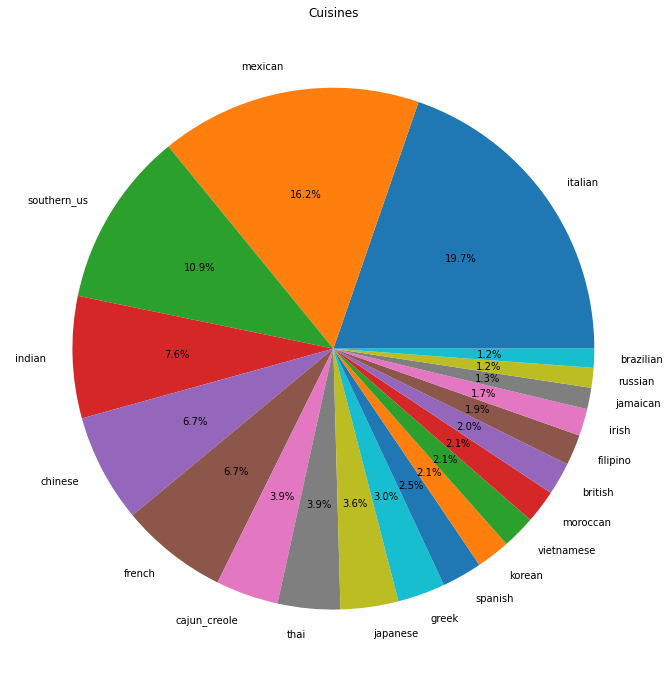

In [ ]:
#pie chart of all the cuisines with percentage of each one

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,12))
df["cuisine"].value_counts().plot.pie(ylabel='', autopct='%1.1f%%', title = "Cuisines")
plt.show()

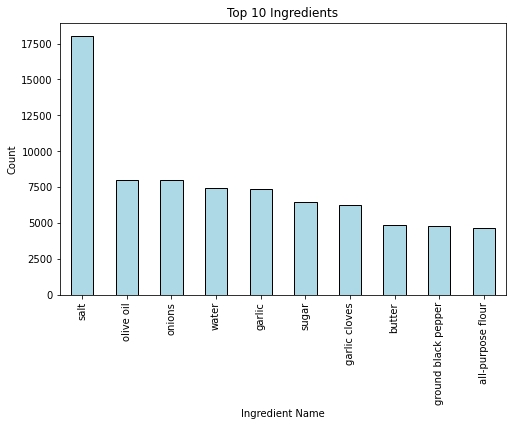

In [ ]:
#Top 10 used ingredients

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))

ingredients_list = []
for i in df['ingredients']:
    for j in i:
        ingredients_list.append(j)

ingredients_list = pd.Series(ingredients_list)

ingredients_list.value_counts().head(10).plot.bar(xlabel='Ingredient Name', ylabel='Count', title="Top 10 Ingredients", color = 'lightblue', edgecolor = 'black', width = 0.5)

## One hot encoding

Since all of our features are binary classifications, we will apply OneHotEncoding, so our machine learning models can easily read our data.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)

X = pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df['ingredients']),
                index=df.index,
                columns=mlb.classes_)

y = df['cuisine']

# Splitting Data

Now that our data has been cleanly organized with our features in the X dataframe and our labels in the y series, we are ready to split these into training and test sets.

We have played with different values for test_size often using values lower than those on the homework because this dataset is much larger than the datasets we have used, and it may not be necessary to have a test set of 10,000+ samples. (Even with a test_size value of .1, we get about 4,000 data samples in the test set)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)


---
# Machine Learning Section⭐

# ***Select this block of code, click Runtime, and choose 'Run before' to run every block up to this point. This will set up the data for the machine learning models***❗
---

## Most of these blocks of code are set up to tune various hyperparameters, where applicable. They do this by creating unique models within a for loop, and recording the accuracies of each model in a list. In the end, the hyperparameters that resulted in the highest accuracies are printed.

## Note: if you find a hyperparameter that results in a higher accuracy than the ones recorded, please note it down in the same section, along with the n_value that achieved it as well as the value used for test_size in the train_test_split() method!

These for loops have been used to test huge ranges of values, so if you want a block of code to run quickly, adjust the outer for loops to loop through a smaller range, or use a larger step size.

# Each group of code (there is a section for each type of model) can be run in any order, so feel free to jump to whichever model you would like to work on.

Note: Each model is made within an iteration, so they are garbage collected each iteration. Thus, RAM should never be an issue. The only data being piled up is the list saving the hyperparameter values with their accuracies, which should take up negligible memory, even for long for loops.

---


# KNN




In [ ]:
from sklearn.neighbors import KNeighborsClassifier
"""
Loop through different n_neighbors values for knn models and print the one that
results in the best accuracy

Adjust the n_range tuple to change the for loop
"""

# values used in for loop (minimum value, maximum value exclusive, step size)
n_range = (10, 100, 1)

# save the accuracies that result of each n_neighbors value as a tuple (n, accuracy_score)
n_values = []

for n in range(n_range[0], n_range[1], n_range[2]):
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train, y_train)
  knn_predict = knn.predict(X_test)
  knn_score = accuracy_score(y_test, knn_predict)

  n_values += [(n, knn_score)]


# Print the n_value that resulted in greatest accuracy
max_value = max(n_values, key=lambda x: x[1])
print(f"max accuracy: {max_value[1]}\nn-value: {max_value[0]}")

max accuracy: 0.5399698340874811
n-value: 16


# KNN Accuracy: 54.0%

The best value we have found for n is 16 which results in an accuracy of 54.0% on the testing set.

---


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state = 3)
dt.fit(X_train, y_train)
dt_predict = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predict)

print(dt_accuracy)

0.6209150326797386


Applying 5-fold, 7-fold and 10-fold cross validation for Decision Tree classifier

In [ ]:
from sklearn.model_selection import cross_val_score

dt2 = DecisionTreeClassifier(random_state = 3)

for i in [5, 7, 10]:
  dt2_accuracy = cross_val_score(dt2, X, y, cv=i, scoring='accuracy')
  dt2_accuracy_cv = dt2_accuracy.mean()
  print(str(i) + "-fold accuracy: " + str(dt2_accuracy_cv))

5-fold accuracy: 0.6085132788202181
7-fold accuracy: 0.6093176446925127
10-fold accuracy: 0.6154774126693546


# Decision Tree Accuracy: 62.1%

This was achieved with test_size of 0.1 (about 4000 data samples)

---



# Voting

Currently set up to test different sizes for voting groups. I would like to also test different bootstrap sizes.

The first block of code generates predictions for n different decision tree classifiers, and saves their predictions in ensemble_predictions.

The rest of the code will perform voting using different amounts of ensembles, starting with 1 (which would just be a simple decision tree classifier) and ending with n. Finally, it outputs which size of group of voters resulted in the greatest accuracy.

In [ ]:
"""
Generate multiple decision trees and their predictions
Save their predictions to be used for voting in the next code block
"""
from sklearn.tree import DecisionTreeClassifier

# Use this to declare (up to) how many decision trees will be used for voting
max_group_size = 20


X_train_size = X_train.shape[0]
bootstrap_size = int(np.floor(.8*X_train_size))

from sklearn.utils import resample

ensemble_predictions = []

for state in range(max_group_size):
    sample_X, sample_y = resample(X_train, y_train, n_samples=bootstrap_size, random_state=state, replace=True)

    dt = DecisionTreeClassifier(random_state=3)
    dt.fit(sample_X, sample_y)

    ensemble_predictions += [dt.predict(X_test)]


# Convert ensemble_predictions to a numpy array, for easier use in voting
ensemble_predictions = np.array(ensemble_predictions)

In [ ]:
"""
Perform voting using various voter sizes
Print the size that produces greatest accuracy
"""

def voting(predictions):
  """
  predictions: a list of predictions on a single sample
  returns: the most common prediction from predictions
  """
  vote_counter = Counter(predictions)
  return max(predictions, key=vote_counter.get)

# Store tuples of (num_voters, accuracy_score)
ensemble_sizes = []

for size in range(ensemble_predictions.shape[0]):
  # This list will contain the voted on predictions for each sample
  voted_predictions = []

  for i in range(ensemble_predictions.shape[1]):
    # grab every prediction for a single column
    ith_sample_predictions = ensemble_predictions[:,i]

    # pass only the predictions of the first (size+1) voters to voting
    voted_predictions += [voting(ith_sample_predictions[:size+1])]
  ensemble_sizes += [(size+1, accuracy_score(voted_predictions, y_test))]

max_value = max(ensemble_sizes, key=lambda x: x[1])
print(max_value)

(19, 0.6830065359477124)


# Highest Voting Accuracy achieved was 68.3% using 47 different decision tree models to vote.

---

# Random Forest

Tests different n_estimators values, outputs n with highest accuracy.

High values of n_estimators take a while. If you are looping through high values, consider a *very* large step size, and even then be patient :)

I have found that after n_estimators=300, accuracy begins to decrease. Optimal value may be between 250 and 350, then. (This is with test_size=0.1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# values used in for loop (minimum value, maximum value exclusive, step size)
n_range = (10, 11, 100)

# save the accuracies that result of each n_neighbors value as a tuple (n, accuracy_score)
n_values = []

for n in range(n_range[0], n_range[1], n_range[2]):
  my_RandomForest = RandomForestClassifier(n_estimators = n, bootstrap = True, random_state=3)
  my_RandomForest.fit(X_train, y_train)
  forest_prediction = my_RandomForest.predict(X_test)
  score_my_RandomForest = accuracy_score(y_test, forest_prediction)

  n_values += [(n, score_my_RandomForest)]

max_value = max(n_values, key=lambda x:x[1])
print(max_value)

(10, 0.6837606837606838)


# Highest Random Forest Accuracy achieved is 73.3% using n_estimators=259


---



# AUC and Roc

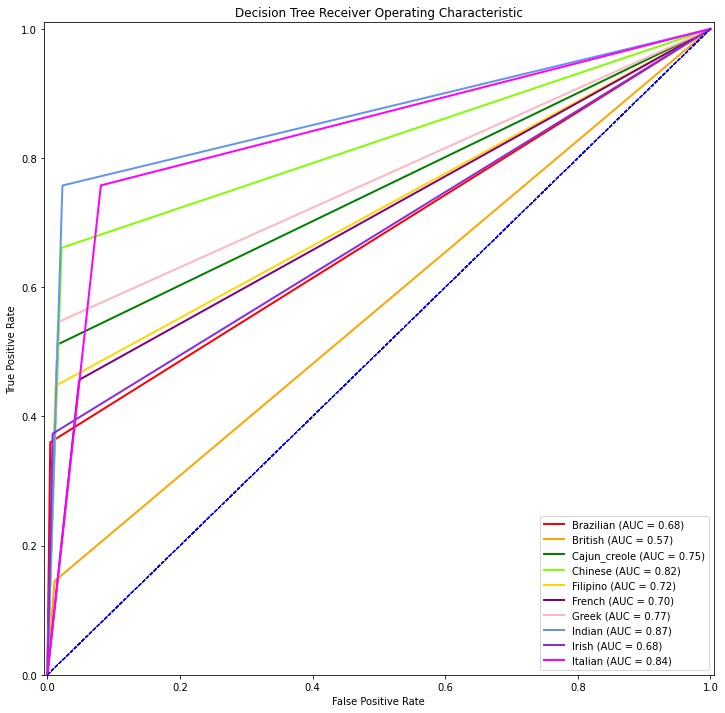

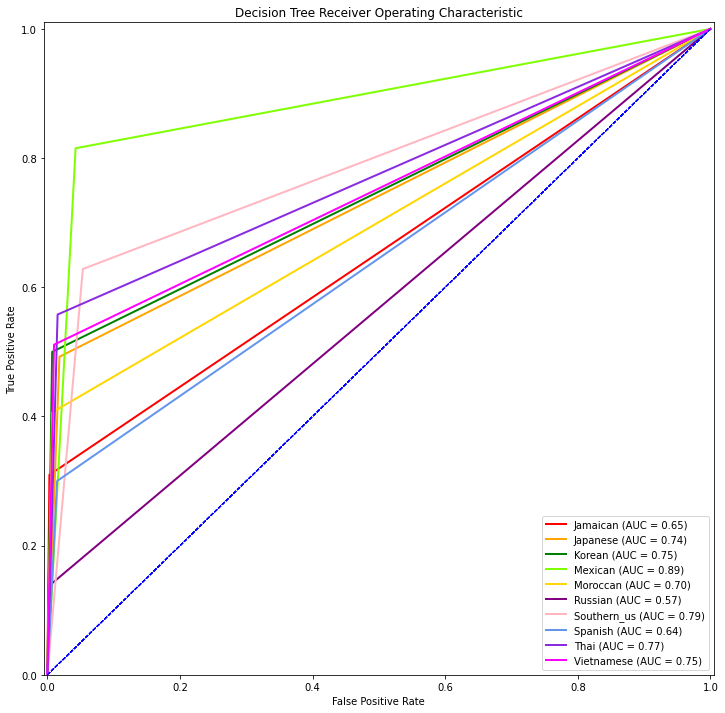

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

color_list=("red", "orange", "green", "chartreuse", "gold",
            "purple", "lightpink", "cornflowerblue", "blueviolet", "fuchsia")

plt.figure(figsize=(12,12))

dt = DecisionTreeClassifier(random_state = 3)
dt.fit(X_train, y_train)

dt_predict_prob = dt.predict_proba(X_test)
classes = dt.classes_

for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, dt_predict_prob[:, i], pos_label=classes[i])

    AUC = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color_list[i%10], lw=2, label= classes[i].capitalize() + ' (AUC = %0.2f)' % AUC)

    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.xlim([-0.005, 1.005])
    plt.ylim([0.0, 1.01])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Decision Tree Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    if i == len(classes)/2 - 1:
      plt.show()
      plt.figure(figsize=(12,12))


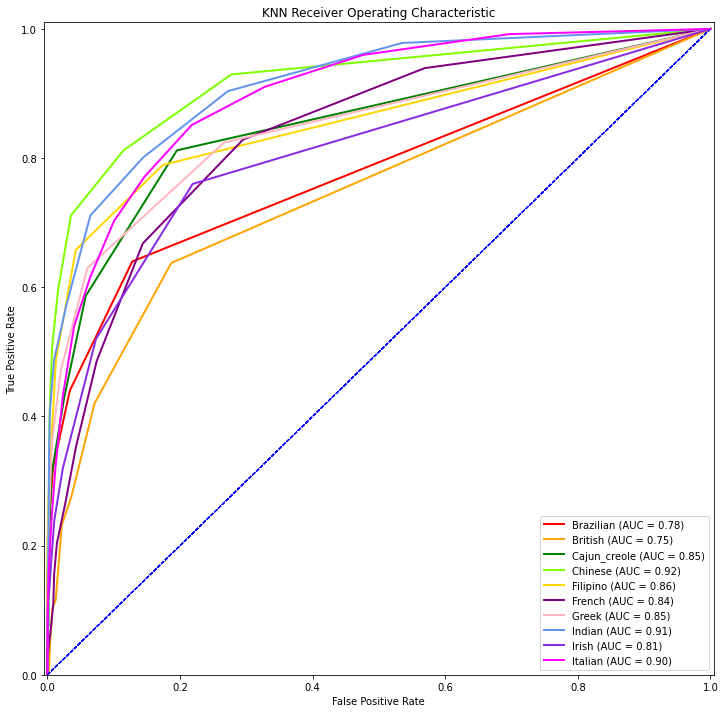

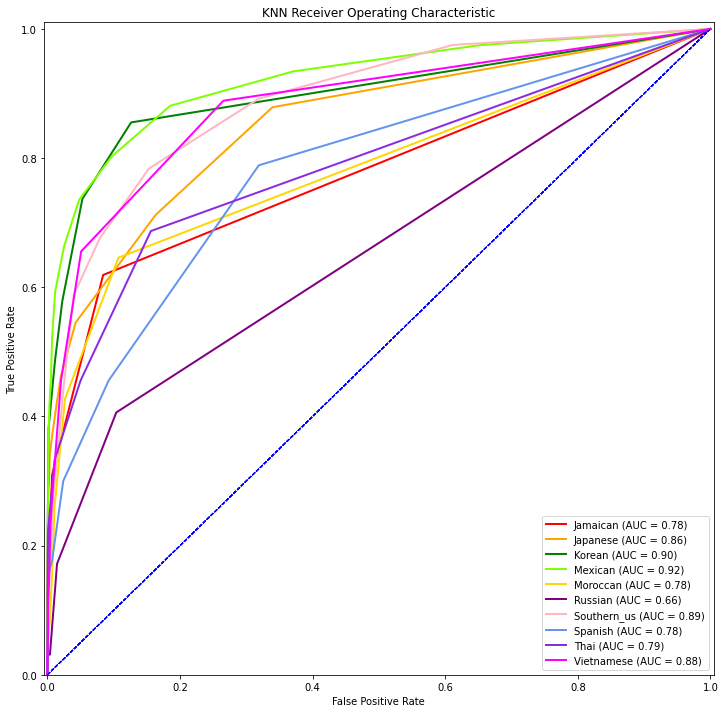

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

color_list=("red", "orange", "green", "chartreuse", "gold",
            "purple", "lightpink", "cornflowerblue", "blueviolet", "fuchsia")

plt.figure(figsize=(12,12))


knn = KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train, y_train)


knn_predict_prob = knn.predict_proba(X_test)
classes = knn.classes_

for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_predict_prob[:, i], pos_label=classes[i])

    AUC = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color_list[i%10], lw=2, label= classes[i].capitalize() + ' (AUC = %0.2f)' % AUC)

    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.xlim([-0.005, 1.005])
    plt.ylim([0.0, 1.01])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('KNN Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    if i == len(classes)/2 - 1:
      plt.show()
      plt.figure(figsize=(12,12))

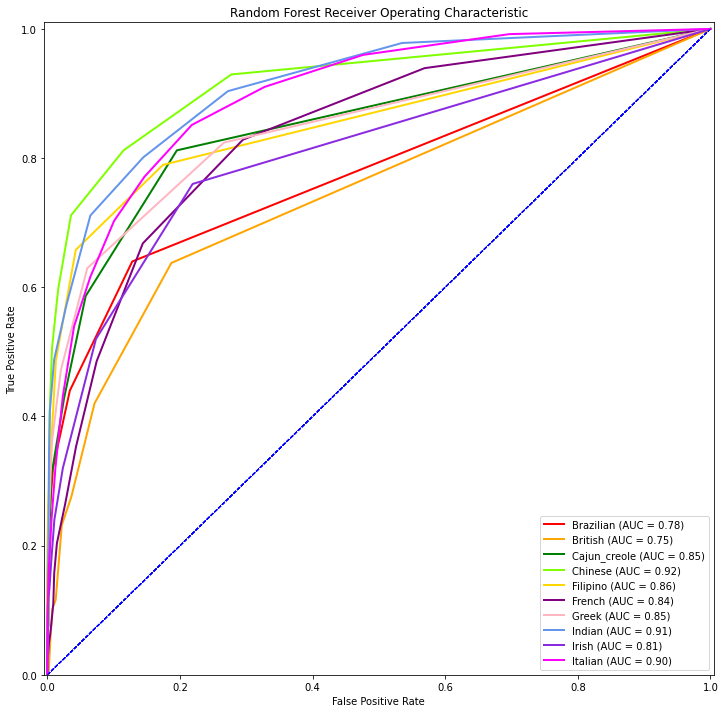

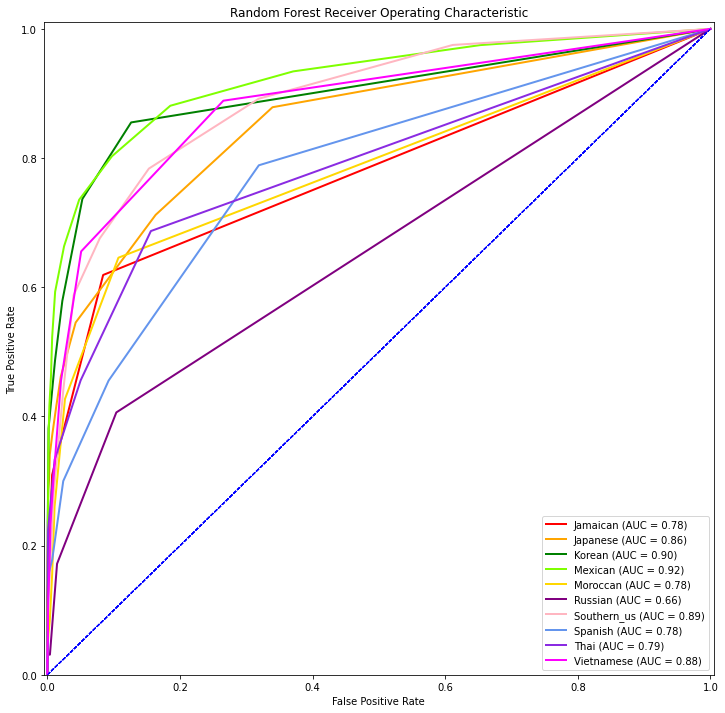

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

color_list=("red", "orange", "green", "chartreuse", "gold",
            "purple", "lightpink", "cornflowerblue", "blueviolet", "fuchsia")

plt.figure(figsize=(12,12))


my_RandomForest = RandomForestClassifier(n_estimators = 259, bootstrap = True, random_state=3)
my_RandomForest.fit(X_train, y_train)

my_RandomForest_predict_prob = knn.predict_proba(X_test)
classes = my_RandomForest.classes_

for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, my_RandomForest_predict_prob[:, i], pos_label=classes[i])

    AUC = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color_list[i%10], lw=2, label= classes[i].capitalize() + ' (AUC = %0.2f)' % AUC)

    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.xlim([-0.005, 1.005])
    plt.ylim([0.0, 1.01])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Random Forest Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    if i == len(classes)/2 - 1:
      plt.show()
      plt.figure(figsize=(12,12))

# Analysis ⛴

In [ ]:
#from sklearn import tree

#tree.plot_tree(dt, max_depth=3)

# from sklearn.tree import export_text

# r = export_text(dt, feature_names=ingredients_list, max_depth=4)

# print(r)

### Conclusion: Currently, random forest has resulted in the highest accuracy on our testing set.

